In [1]:
# # we will follow the pytorch documentation at : https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
# and we might use some of the classes from our implementation of a vision transformer

In [20]:
import numpy as np , pandas as pd
import torch
import torch.nn as nn

import torchvision.transforms as transforms
import torch.utils as utils

import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
fer = pd.read_csv("../archive/fer2013/fer2013/fer2013.csv")
fer[:2] # show first 2 examples

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training


In [8]:
fer_train = fer[fer.Usage == "Training"]
fer_valid = fer[fer.Usage == "PublicTest"]
fer_test = fer[fer.Usage == "PrivateTest"]

fer_train.shape ,fer_valid.shape, fer_test.shape

((28709, 3), (3589, 3), (3589, 3))

In [9]:
# from vit: without the patches
class FerDataset(utils.data.Dataset):
    """
    Keep the validation
    and test set seperate for now.
    Dont plan to use early stopping.
    just to make sure we are not leaking into validation Dataset
    """

    def __init__(self,df,label = None, transformations = None):
        super().__init__()
        if label not in ("train", "test", "valid"):
            raise ValueError("Please give al label to this dataset class train , valid , test")

        # handy stuff that i often call
        self.label = label

        self.data = df[df.columns[:-1]] # the last column is just usage
        self.columns = self.data.columns
        self.shape = self.data.shape
        self.transforms = transformations

        if self.transforms is None:
            self.transforms = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((32,32), antialias=True)]) # limit number of patches (4) calculation.. keep this a multiple of 16*16

    # mandatory method to calculate random indexes when you turn on shuffle in dataloader
    def __len__(self):
        return self.shape[0]


    def __getitem__(self, idx):
        # convert to string type

        self.data = self.data.astype({"emotion": int, "pixels": str})

        features = self.data.iloc[idx]['pixels']
        features = np.array(features.split(" "),dtype=np.uint8) # its a flatten of 48 * 48 * 1 image
        # image = features.view(48,48) -> numpy view is like astype with view not like torch.view
        image = features.reshape(48,48)
        if self.transforms:
            image = self.transforms(image)


        label = self.data.iloc[idx]['emotion']


        return image, label # dont use capital Tensor it will convert it into float

    @staticmethod
    def imshow(img):
        plt.figure(figsize=(5,5))
        img = torch.einsum("bhw -> hw",img) # squeeze out the batch dimension
        plt.imshow(img, cmap="gray")
        plt.axis("off")

        plt.show()


In [10]:
fer = FerDataset(fer_train, "train")
img,lab = fer[0]

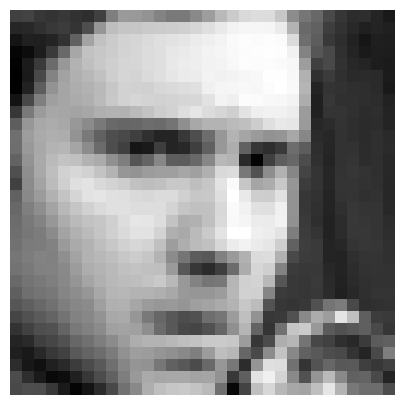

In [11]:
fer.imshow(img)

In [15]:
train_data = FerDataset(fer_train,"train")
train_loader = utils.data.DataLoader(train_data, shuffle=True, batch_size=32)

valid_data = FerDataset(fer_valid,"valid")
valid_loader = utils.data.DataLoader(valid_data, shuffle=True, batch_size=32)

test_data = FerDataset(fer_test,"test")
test_loader = utils.data.DataLoader(test_data, shuffle=True, batch_size=32)

In [16]:
for data in train_loader:
    img, label = data
    print(img.shape, label)
    break

torch.Size([32, 1, 32, 32]) tensor([6, 3, 4, 3, 2, 3, 3, 6, 6, 0, 3, 4, 4, 0, 4, 6, 3, 0, 5, 0, 0, 4, 0, 4,
        2, 3, 2, 6, 4, 4, 3, 4])


In [17]:
# define a small convolutional network
# see beautiful mnist in tinygrad .
import torch.nn as nn
import torch.nn.functional as F

# shape after operations n,n ->(with padding p and stride s) (n + 2p - f + 1 )/s + 1

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2) # this is not a learnable operaation just performs downsampling
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7) # we have 7 classes 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits


net = Net()

In [18]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# define optimizer
# only train the parameters with requires_grad set to True
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.0001)


In [19]:
# Check for a GPU
train_on_gpu = torch.cuda.is_available()
train_on_gpu

False

In [21]:
# Train model

# number of epochs ... this needs to be way higher .
# mostly transformer based model are done for really high epochs
n_epoch = 10

train_loss_list, valid_loss_list = [], []

# move model to GPU
if train_on_gpu:
    net.to('cuda')

# prepare model for training
net.train()

for e in range(n_epoch):
    train_loss = 0.0
    valid_loss = 0.0

    # get batch data
    for i, (images, targets) in tqdm( enumerate(train_loader)):

        # move to gpu if available
        if train_on_gpu:
            images, targets = images.to('cuda'), targets.to('cuda')

        # clear grad
        optimizer.zero_grad()

        # feedforward data
        outputs = net(images)

        # calculate loss
        loss = criterion(outputs, targets)

        # backward pass, calculate gradients
        loss.backward()

        # update weights
        optimizer.step()

        # track loss
        train_loss += loss.item()

    # set model to evaluation mode
    net.eval()

    # validate model
    for images, targets in valid_loader:

        # move to gpu if available
        if train_on_gpu:
            images = images.to('cuda')
            targets = targets.to('cuda')

        # turn off gradients
        with torch.no_grad():

            outputs = net(images)
            loss = criterion(outputs, targets)
            valid_loss += loss.item()

    # set model back to training mode
    net.train()

    # get average loss values
    train_loss = train_loss / len(train_loader)
    valid_loss = valid_loss / len(valid_loader)

    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

    # output training statistics for epoch
    print('Epoch: {} \t Training Loss: {:.6f} \t Validation Loss: {:.6f}'
          .format( (e+1), train_loss, valid_loss))



898it [00:43, 20.71it/s]


Epoch: 1 	 Training Loss: 1.805963 	 Validation Loss: 1.772507


898it [00:41, 21.40it/s]


Epoch: 2 	 Training Loss: 1.746161 	 Validation Loss: 1.706885


898it [00:42, 21.27it/s]


Epoch: 3 	 Training Loss: 1.694734 	 Validation Loss: 1.666789


898it [00:43, 20.78it/s]


Epoch: 4 	 Training Loss: 1.664939 	 Validation Loss: 1.649109


898it [00:42, 21.13it/s]


Epoch: 5 	 Training Loss: 1.645597 	 Validation Loss: 1.632843


898it [00:42, 21.03it/s]


Epoch: 6 	 Training Loss: 1.628108 	 Validation Loss: 1.614531


898it [00:42, 21.02it/s]


Epoch: 7 	 Training Loss: 1.611470 	 Validation Loss: 1.600102


898it [00:44, 20.01it/s]


Epoch: 8 	 Training Loss: 1.594062 	 Validation Loss: 1.585548


898it [00:41, 21.59it/s]


Epoch: 9 	 Training Loss: 1.577224 	 Validation Loss: 1.573340


898it [00:42, 21.14it/s]


Epoch: 10 	 Training Loss: 1.559891 	 Validation Loss: 1.551194


In [22]:
torch.save(net.state_dict(), "./conv_weights.pth")

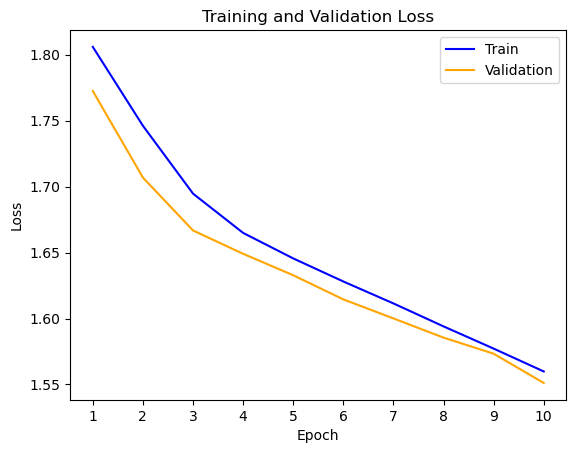

In [23]:
# visualize loss statistics

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# plot losses
x = list(range(1, n_epoch + 1))
plt.plot(x, train_loss_list, color ="blue", label='Train')
plt.plot(x, valid_loss_list, color="orange", label='Validation')
plt.legend(loc="upper right")
plt.xticks(x)

plt.show()

In [25]:
# test loss (showed no overfitting)
import torch.nn.functional as F
# prepare model for evaluation
net.eval()

test_loss = 0.0
accuracy = 0

# number of classes
n_class = 7

class_correct = np.zeros(n_class)
class_total = np.zeros(n_class)

# move model back to cpu
net = net.to('cpu')

# test model
for images, targets in tqdm(test_loader):

    # get outputs
    outputs = net(images)

    # calculate loss
    loss = criterion(outputs, targets)

    # track loss
    test_loss += loss.item()

    # get predictions from probabilities
    preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)

    # get correct predictions
    correct_preds = (preds == targets).type(torch.FloatTensor)

    # calculate and accumulate accuracy
    accuracy += torch.mean(correct_preds).item() * 100

    # calculate test accuracy for each class
    for c in range(n_class):

        targets = targets.to('cpu')

        class_total[c] += (targets == c).sum()
        class_correct[c] += ((correct_preds) * (targets == c)).sum()

# get average accuracy
accuracy = accuracy / len(test_loader)

# get average loss
test_loss = test_loss / len(test_loader)

# output test loss statistics
print('Test Loss: {:.6f}'.format(test_loss))


100%|██████████| 113/113 [00:02<00:00, 53.20it/s]

Test Loss: 1.556882


In [26]:
classes =  ["Angry","Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

In [27]:
class_accuracy = class_correct / class_total

print('Test Accuracy of Classes')
print()

for c in range(n_class):
    print('{}\t: {}% \t ({}/{})'.format(classes[c],
                                        int(class_accuracy[c] * 100), int(class_correct[c]), int(class_total[c])) )

print()
print('Test Accuracy of Dataset: \t {}% \t ({}/{})'.format(int(accuracy),
                                                           int(np.sum(class_correct)), int(np.sum(class_total)) ))

Test Accuracy of Classes

Angry	: 10% 	 (54/491)
Disgust	: 0% 	 (0/55)
Fear	: 7% 	 (41/528)
Happy	: 80% 	 (710/879)
Sad	: 32% 	 (191/594)
Surprise	: 47% 	 (197/416)
Neutral	: 33% 	 (208/626)

Test Accuracy of Dataset: 	 39% 	 (1401/3589)
